<a href="https://colab.research.google.com/github/Jorgellamocca/Cambio-Clim-tico/blob/main/cmip6_modelos_obs_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# INSTALACIÓN + IMPORTS
# ============================================================
!pip install -q intake intake-esm xarray netcdf4 zarr cartopy shapely pyproj fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp

import intake
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["figure.dpi"] = 120

In [3]:
# ============================================================
# DEFINIR DOMINIO COMÚN + PERIODO CLIMATOLÓGICO (1981–2010)
# ============================================================

# Dominio común "Piura ampliado" (como tu ejemplo)
DOMINIO = dict(
    lat=slice(-8.5, -2.2),
    lon=slice(-81.5, -77.5)
)

# Dominio común "Cusco" (como tu ejemplo)
#DOMINIO = dict(
#    lat=slice(-15.5, -11.5),
#    lon=slice(-76.5, -69.5)
#)

# Periodo climatológico base
PERIODO_CLIM = slice("1981-01", "2010-12")

# Punto para serie temporal (Cambiar para la region se trabajo)
LAT_PTO = -6.0
LON_PTO = -80.0

# Punto para serie temporal (Cambiar para la region se trabajo)
#LAT_PTO = -13.5
#LON_PTO = -71.9


# Fecha de ejemplo para mapas
FECHA_EJEMPLO = "1990-01"

LAT_MIN = DOMINIO["lat"].start
LAT_MAX = DOMINIO["lat"].stop
LON_MIN = DOMINIO["lon"].start
LON_MAX = DOMINIO["lon"].stop

proj = ccrs.PlateCarree()

In [4]:
# ============================================================
# FUNCIONES ÚTILES
# ============================================================
def fix_lon_cmip(ds):
    """0–360 -> -180–180 para CMIP6"""
    if "lon" in ds.coords:
        ds = ds.assign_coords(lon=((ds.lon + 180) % 360) - 180).sortby("lon")
    return ds

def fix_lon_era(ds):
    """0–360 -> -180–180 para ERA5 (longitude)"""
    if "longitude" in ds.coords:
        ds = ds.assign_coords(longitude=((ds.longitude + 180) % 360) - 180).sortby("longitude")
    return ds

def squeeze_cmip_da(da):
    """
    Quita dims extra típicas de CMIP6 si existen
    (member_id, dcpp_init_year, etc.) tomando el índice 0.
    """
    for d in ["member_id", "dcpp_init_year", "variant_label", "realization", "init_year"]:
        if d in da.dims:
            da = da.isel({d: 0})
    return da.squeeze()

def plot_map_pr(da2d, title):
    """Mapa simple de precipitación mensual (2D lat-lon)."""
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection=proj)
    ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=proj)

    #ax.set_extent(extent, crs=proj)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    im = ax.pcolormesh(
        da2d.lon,
        da2d.lat,
        da2d.values,
        cmap="Blues",
        shading="auto",
        transform=proj,
        vmin=0,
        vmax=650
    )

    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("Precipitación (mm/mes)")
    cbar.set_ticks(np.arange(0, 651, 50))

    ax.set_title(title, fontweight="bold")
    plt.tight_layout()
    plt.show()


Abriendo ACCESS-ESM1-5 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ ACCESS-ESM1-5 cargado
  dims plot: ('lat', 'lon'), shape=(5, 2)


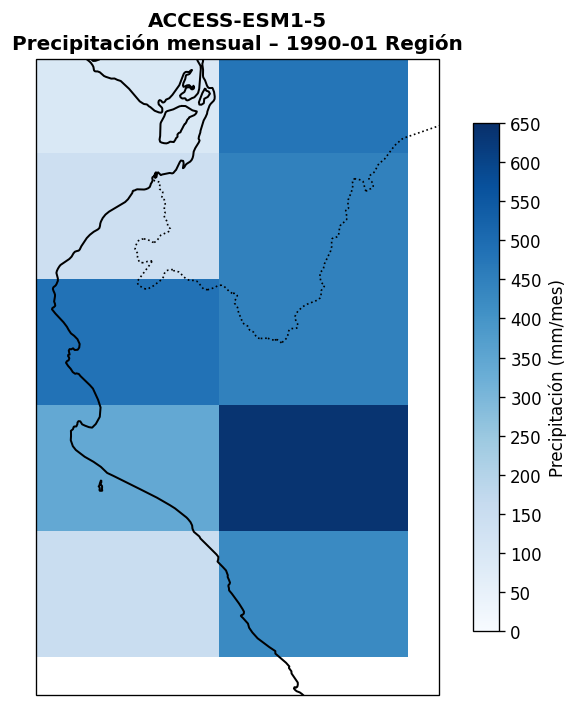


Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado
  dims plot: ('lat', 'lon'), shape=(7, 4)


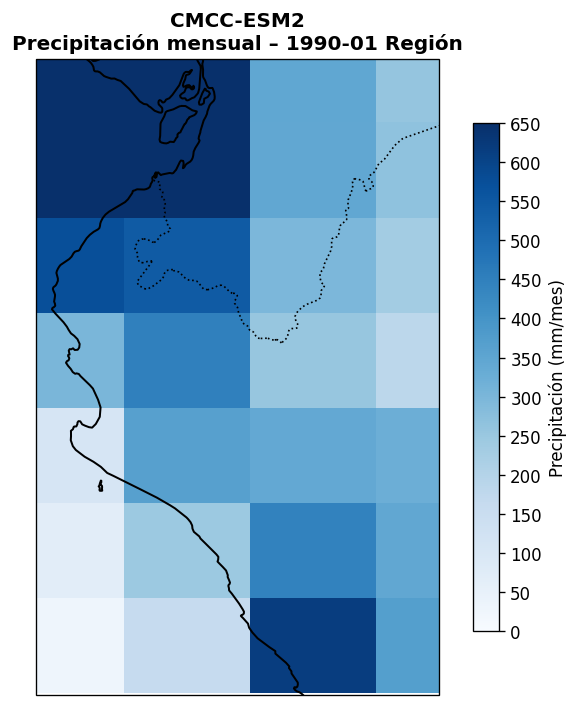


Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CNRM-CM6-1 cargado
  dims plot: ('lat', 'lon'), shape=(4, 2)


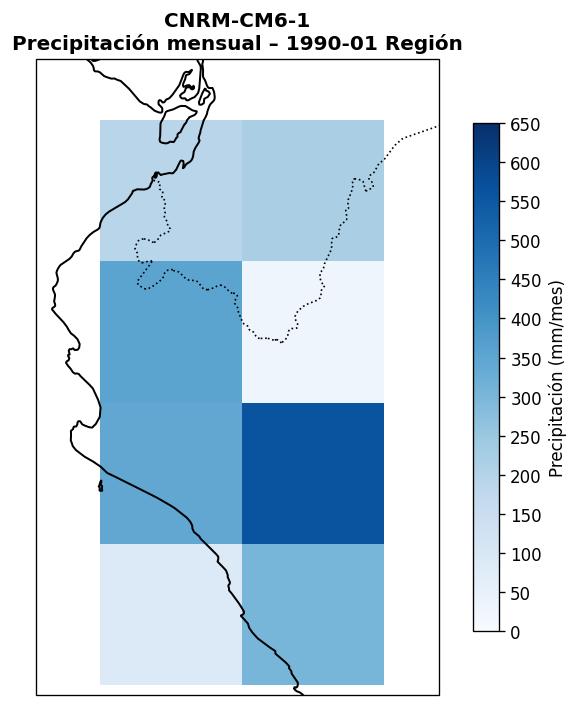


Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado
  dims plot: ('lat', 'lon'), shape=(6, 4)


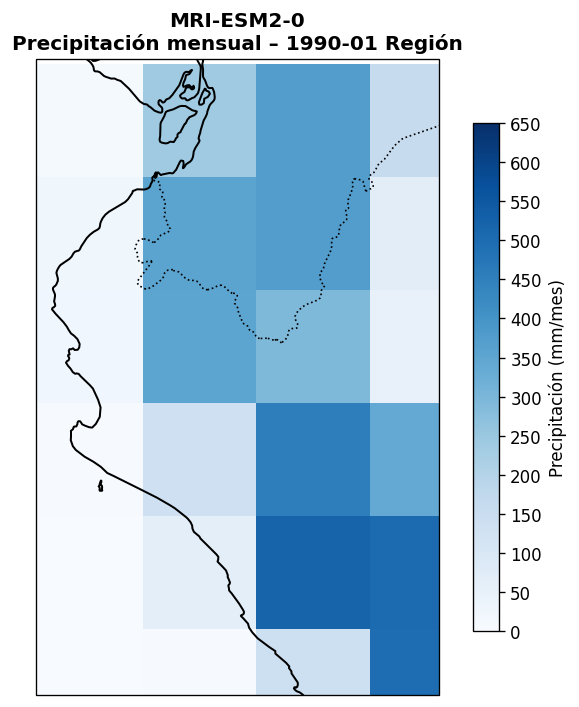


Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado
  dims plot: ('lat', 'lon'), shape=(7, 4)


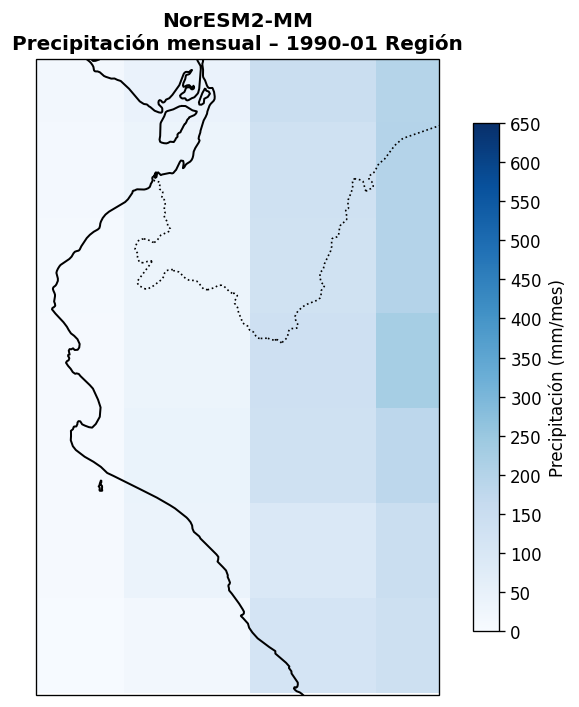

In [5]:
# ============================================================
# LEER 5 MODELOS CMIP6 MENSUAL (pr), DEFINIR VARIABLE POR MODELO
# ============================================================
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(cat_url)

MODELOS = {
    "ACCESS-ESM1-5": "r1i1p1f1",
    "CMCC-ESM2":     "r1i1p1f1",
    "CNRM-CM6-1":    "r1i1p1f2",
    "MRI-ESM2-0":    "r1i1p1f1",
    "NorESM2-MM":    "r1i1p1f1"
}

datasets = {}
pr_por_modelo = {}   # aquí guardaremos pr mensual (mm/mes) por modelo

for modelo, member in MODELOS.items():
    print(f"\nAbriendo {modelo} ({member})...")

    cat_tmp = cat.search(
        activity_id="CMIP",
        source_id=modelo,
        experiment_id="historical",
        table_id="Amon",
        variable_id="pr",
        member_id=member
    )

    if len(cat_tmp.df) == 0:
        print(f"  ❌ {modelo}: no disponible en este filtro")
        continue

    ds_dict = cat_tmp.to_dataset_dict(
        zarr_kwargs={"consolidated": False},
        storage_options={"token": "anon"},
        xarray_open_kwargs={"use_cftime": True}
    )

    ds = list(ds_dict.values())[0]
    ds = fix_lon_cmip(ds)
    datasets[modelo] = ds
    print(f"  ✅ {modelo} cargado")

    # ---- pr mensual mm/mes para TODOS
    days_in_month = ds.time.dt.days_in_month
    pr_modelo = ds["pr"] * 86400 * days_in_month
    pr_modelo.attrs["units"] = "mm/mes"

    pr_por_modelo[modelo] = pr_modelo

    # ---- mapa ejemplo ----
    pr_area = pr_modelo.sel(**DOMINIO)
    pr_plot = pr_area.sel(time=FECHA_EJEMPLO)
    pr_plot = squeeze_cmip_da(pr_plot)


    # verificación dims
    print(f"  dims plot: {pr_plot.dims}, shape={pr_plot.shape}")

    plot_map_pr(
        pr_plot,
        title=f"{modelo}\nPrecipitación mensual – {FECHA_EJEMPLO} Región"
    )

In [ ]:
#LEER ERA5

In [6]:
!pip install -q xarray zarr fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp > /dev/null 2>&1
!apt-get install -qq -y libproj-dev proj-data proj-bin libgeos-dev > /dev/null 2>&1
!pip install -q cartopy shapely pyproj > /dev/null 2>&1

In [7]:
import xarray as xr
xr.backends.list_engines()

{'netcdf4': <NetCDF4BackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html,
 'h5netcdf': <H5netcdfBackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html,
 'scipy': <ScipyBackendEntrypoint>
   Open netCDF files (.nc, .cdf and .nc.gz) using scipy in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html,
 'kerchunk': <KerchunkBackend>
   Open Kerchunk References with Xarray
   Learn more at https://fsspec.github.io/kerchunk/,
 'pydap': <PydapBackendEntrypoint>
   Open remote datasets via OPeNDAP using pydap in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.PydapBackendEntrypoint.html,
 'store': <S

In [8]:
#Usar token registrado
TOKEN = "edh_pat_fcb2e9f52c35ff7fd7cc2f2d14317393c9e299c8c1c1f81a94216161433a0943f554036a62b849c1af67f0c0400c31e3"

# Crear el archivo
with open("/root/.netrc", "w") as f:
    f.write("machine data.earthdatahub.destine.eu\n")
    f.write(f"  password {TOKEN}\n")

# Permisos
!chmod 600 /root/.netrc


Abriendo ERA5 mensual...
ERA5 area shape: (1031, 26, 17)


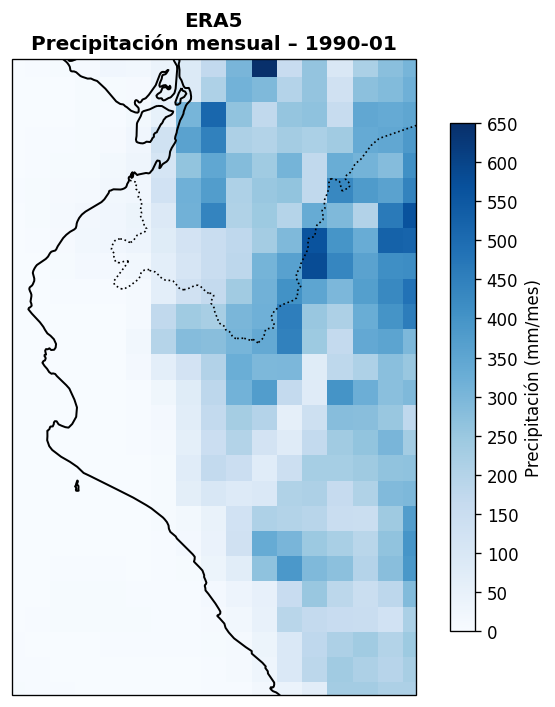

In [9]:
# ============================================================
# 3) ERA5 – LECTURA + MAPA EJEMPLO (CORREGIDO)
# ============================================================
print("\nAbriendo ERA5 mensual...")

era = xr.open_dataset(
    "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr",
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

era = fix_lon_era(era)
era = era.sortby("latitude")
era = era.sortby("longitude")

fechas = pd.to_datetime(era.valid_time.values)
dias_mes = xr.DataArray(
    fechas.days_in_month,
    coords={"valid_time": era.valid_time},
    dims=["valid_time"]
)

pr_era5_all = era.tp * 1000 * dias_mes
pr_era5_all.attrs["units"] = "mm/mes"

pr_era5_area = pr_era5_all.sel(
    latitude=slice(DOMINIO["lat"].start, DOMINIO["lat"].stop),
    longitude=slice(DOMINIO["lon"].start, DOMINIO["lon"].stop)
)

print("ERA5 area shape:", pr_era5_area.shape)

pr_era5_plot = (
    pr_era5_area
    .sel(valid_time=FECHA_EJEMPLO)
    .squeeze()
    .rename({"latitude": "lat", "longitude": "lon"})
)

plot_map_pr(
    pr_era5_plot,
    f"ERA5\nPrecipitación mensual – {FECHA_EJEMPLO}"
)

Meses comunes: 360
Inicio: 198101 Fin: 201012


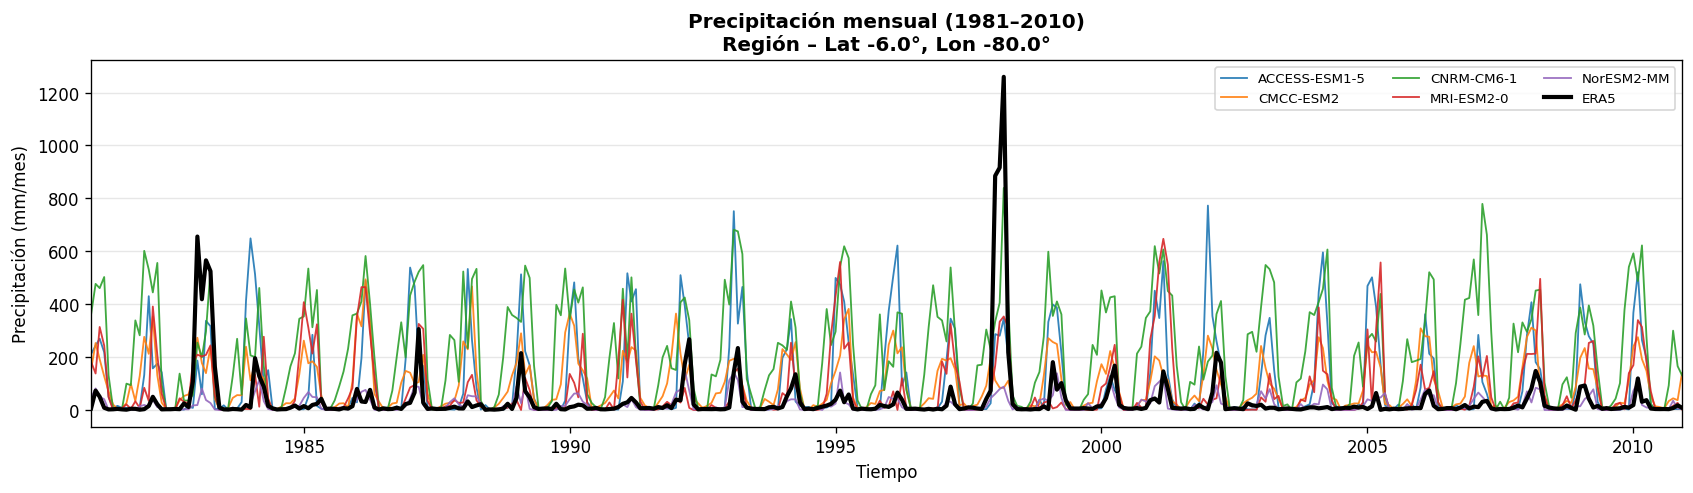

In [10]:
# ============================================================
# SERIE COMPLETA 1981–2010 EN (LAT=-6, LON=-80)
# COMPARAR 5 MODELOS vs ERA5  (ALINEACIÓN ROBUSTA + BUENA ESTÉTICA)
import matplotlib.dates as mdates

# ------------------------------------------------------------
# ERA5: SERIE TEMPORAL EN EL PUNTO
# ------------------------------------------------------------
pr_era5_point = (
    pr_era5_all
    .sel(valid_time=PERIODO_CLIM)
    .sel(latitude=LAT_PTO, longitude=LON_PTO, method="nearest")
    .rename(valid_time="time")
    .squeeze()
)

# Clave mensual YYYYMM (datetime64)
era_ym = (pr_era5_point.time.dt.year * 100 +
          pr_era5_point.time.dt.month).astype(int)

pr_era5_point = (
    pr_era5_point
    .assign_coords(ym=("time", era_ym.values))
    .swap_dims({"time": "ym"})
    .drop_vars("time")
)


# ------------------------------------------------------------
# CMIP6: SERIES TEMPORALES EN EL PUNTO
# ------------------------------------------------------------
series_cmip = {}

for modelo, pr in pr_por_modelo.items():

    s = (
        pr.sel(time=PERIODO_CLIM)
          .sel(lat=LAT_PTO, lon=LON_PTO, method="nearest")
    )

    s = squeeze_cmip_da(s)

    # Clave mensual YYYYMM (cftime compatible)
    cmip_ym = (s.time.dt.year * 100 +
               s.time.dt.month).astype(int)

    s = (
        s.assign_coords(ym=("time", cmip_ym.values))
         .swap_dims({"time": "ym"})
         .drop_vars("time")
    )

    series_cmip[modelo] = s


# ------------------------------------------------------------
# INTERSECCIÓN COMÚN DE MESES
# ------------------------------------------------------------
common_ym = set(pr_era5_point.ym.values.tolist())

for s in series_cmip.values():
    common_ym = common_ym.intersection(set(s.ym.values.tolist()))

common_ym = np.array(sorted(common_ym))

print("Meses comunes:", len(common_ym))
print("Inicio:", common_ym[0], "Fin:", common_ym[-1])


# ------------------------------------------------------------
# RECORTE FINAL
# ------------------------------------------------------------
pr_era5_aligned = pr_era5_point.sel(ym=common_ym)
series_cmip_aligned = {
    m: s.sel(ym=common_ym) for m, s in series_cmip.items()
}


# ------------------------------------------------------------
# GRÁFICO FINAL (PRESENTACIÓN MEJORADA)
# ------------------------------------------------------------

# Eje temporal bonito
time_plot = pd.to_datetime(common_ym.astype(str), format="%Y%m")

plt.figure(figsize=(14, 4), constrained_layout=True)

# Modelos CMIP6
for modelo, serie in series_cmip_aligned.items():
    plt.plot(
        time_plot,
        serie.values,
        lw=1.1,
        alpha=0.9,
        label=modelo
    )

# ERA5 destacado
plt.plot(
    time_plot,
    pr_era5_aligned.values,
    color="black",
    lw=2.5,
    label="ERA5",
    zorder=5
)

# Título
plt.title(
    f"Precipitación mensual (1981–2010)\n"
    f"Región – Lat {LAT_PTO}°, Lon {LON_PTO}°",
    fontweight="bold"
)

plt.xlabel("Tiempo")
plt.ylabel("Precipitación (mm/mes)")

# ---- AJUSTES CLAVE DEL EJE X ----
plt.margins(x=0)
plt.xlim(time_plot[0], time_plot[-1])

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5)) # cada 5 años
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Grid solo horizontal (más limpio)
ax.grid(axis="y", alpha=0.3)
ax.grid(axis="x", alpha=0)

plt.legend(ncol=3, fontsize=8)
plt.show()